# CNN first model

Here I use a network doing a CNN over the input. The model architecture is a CNN of the local features. These then get pooled down to the number of channels, which is then fed into a dense layer.

### Load Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn, cuda
from torch.utils.data.dataloader import DataLoader
from utils import Runner, TcrDataset, setup_seed
from cnn_network import SimpleCNN
import pandas as pd

In [16]:
def reverse_one_hot(arr):
        mapping = dict(zip(range(20), "ACDEFGHIKLMNPQRSTVWY"))
        seq = ""
        for j in range(arr.shape[1]):
            pos = arr[:, j]
            if np.argmax != 0:
                seq += mapping[np.argmax(pos)]
        return seq

Set general plotting parameters for matplotlib using seaborn

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette="pastel")

### General parameters

In [3]:
# General parameters
data_dir = "../../data/"
data_files = [data_dir+f"datasets/P{i}_input_cdrs.npz" for i in range(1,6)]
label_files = [data_dir+f"datasets/P{i}_labels.npz" for i in range(1,6)]
model_name = "cnn_model.pt"
model_path = "stored_models/"

batch_size = 64
seed= 123

setup_seed(seed)
device = torch.device("cuda" if cuda.is_available() else "cpu")
#device= torch.device("cpu")

## Define indexing

In [4]:

# Peptide + All CDRS
idx = np.arange(179,248)

# Sequence
local_features = np.arange(20)
global_features = None
use_global_features = False


## Load Data
Partitions can be changed by altering the `data_files` and `label_files` indexing

In [5]:
test_data = TcrDataset(data_files[4], label_files[4])
# Shuffle data randomly is needed
test_data.shuffle_data()
# slicing sequence dimension
test_data.slice_data(idx)
test_data.to_blossum()

input_len = test_data.data.shape[2]

In [6]:
test_dl = DataLoader(test_data, batch_size)

In [7]:
test_data.data.shape

(1207, 54, 69)

In [8]:
# Layer parameters
cnn_channels = 30
hidden_neurons = 64
dropout = 0.4
cnn_kernel = 3

loss_weight = len(test_data) / sum(test_data.labels)
criterion = nn.BCELoss(reduction='none')

In [9]:
net = SimpleCNN(local_features, global_features, use_global_features, cnn_channels=cnn_channels, dropout=dropout, cnn_kernel_size=cnn_kernel, dense_neurons=hidden_neurons)
net.load_state_dict(torch.load(model_path + model_name))
net.to(device)
initial_net = SimpleCNN(local_features, global_features, use_global_features, cnn_channels=cnn_channels, dropout=dropout, cnn_kernel_size=cnn_kernel, dense_neurons=hidden_neurons)
initial_net.to(device)

test_runner = Runner(test_dl, net, criterion, loss_weight, device)

Also load data as only one observed peptide. Meaning that there will only be 16 observations. This is to avoid having the GIL peptide overshadow what positions are important for the general peptide population. The reason can be seen by the peptide counts shown below.

In [17]:
peptides = test_runner.loader.dataset.data[:, :20, :9]
peptides = np.array([reverse_one_hot(peptides[i]) for i in range(len(peptides))])
peptide_counts = np.unique(peptides, return_counts=True)
peptide_counts

(array(['CLGGLLTMV', 'FLYALALLL', 'GILGFVFTL', 'GLCTLVAML', 'IMDQVPFSV',
        'KLQCVDLHV', 'KTWGQYWQV', 'KVLEYVIKV', 'LLFGYPVYV', 'MLDLQPETT',
        'NLVPMVATV', 'RMFPNAPYL', 'RTLNAWVKV', 'SLFNTVATL', 'SLLMWITQV',
        'YLLEMLWRL'], dtype='<U9'),
 array([  2,  22, 686, 239,   6,   2,  15,   6,  37,   7, 136,   9,  18,
          5,  10,   7]))

In [18]:
peptide_indexes = [np.where(peptides == peptide)[0][0] for peptide in peptide_counts[0]]
unique_pep_data = test_runner.loader.dataset.data[peptide_indexes]
unique_pep_labels = test_runner.loader.dataset.labels[peptide_indexes]
unique_dataset = [[data[0], data[1]] for data in zip(unique_pep_data, unique_pep_labels)]
unique_dl = DataLoader(unique_dataset, batch_size=batch_size)
unique_runner = Runner(unique_dl, net, criterion, loss_weight, device)

## Analysis of Max pooling indexes
The hyptothesis here is based on how the CNN and maxpooling would interact. The hope is that one filter learns specific things, that are important for each position in the peptide/cdrs. By looking at the max pooling indexes we can see what position contributes with information in the dense layer. 

I need to know the amount of peptides in each group since there is big imbalance, and since we are only looking at peptide first. All identical peptides would pool in the same manner.

### Unique peptide analysis
Count the number of times each position is selected when doing maxpooling. Done for only unique peptides here

In [31]:
len(unique_dataset)

16

In [34]:
pool_out, conv_out, idxs = unique_runner.get_pool_idxs()

total_counts = np.zeros((11))
start_pos = np.zeros((11))
for i, filter in enumerate(idxs):
    positions, counts = torch.unique(filter, return_counts=True)
    for pos, count in zip(positions, counts):
        total_counts[pos] += count
        total_counts[pos+1] += count
        total_counts[pos+2] += count
        start_pos[pos] += count
        

Total number of counts is $ n_{filters} \cdot n_{obs} \cdot kernelSize $ ($30 \cdot 16 \cdot 3 = 1440$)

Doing the same analysis on a completely new network might show a different distribution of chosen positions

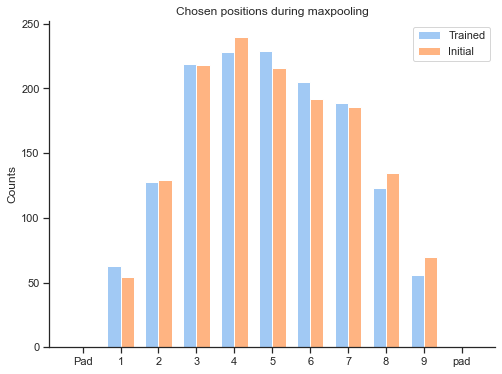

In [35]:
unique_runner.model = initial_net
pool_out, conv_out, idxs = unique_runner.get_pool_idxs()

total_counts_init = np.zeros((11))
start_pos_init = np.zeros((11))
for i, filter in enumerate(idxs):
    positions, counts = torch.unique(filter, return_counts=True)
    for pos, count in zip(positions, counts):
        total_counts_init[pos] += count
        total_counts_init[pos+1] += count
        total_counts_init[pos+2] += count
        start_pos_init[pos] += count


labels = ["Pad", "1", "2", "3", "4", "5", "6", "7", "8", "9", "pad"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, total_counts, width, label='Trained')
rects2 = ax.bar(x + width/2, total_counts_init, width, label='Initial')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Chosen positions during maxpooling')
ax.set_xticks(x, labels)
ax.legend()

unique_runner.model = net

Keep in mind that more filters are overlapping with the middle positions, than the outlier positions. When looking at the possible filter positions that are possible.

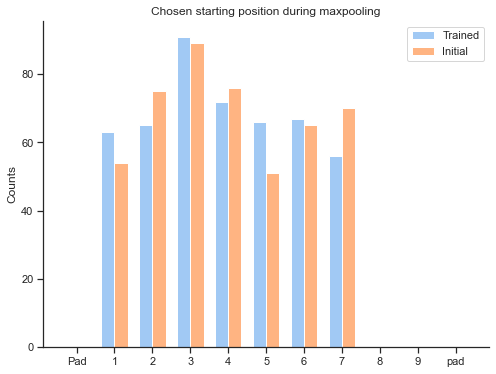

In [36]:
fig, ax = plt.subplots(figsize=(8,6))

rects1 = ax.bar(x - width/2, start_pos, width, label='Trained')
rects2 = ax.bar(x + width/2, start_pos_init, width, label='Initial')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Chosen starting position during maxpooling')
ax.set_xticks(x, labels)
ax.legend()


The peptide cannot start with position 9 Since the kernel will only be 9 long. The filter starting at first pad and 8 cannot be chosen either, since they contain padding.

### All peptides analysis
Count the number of times each position is selected when doing maxpooling. Done for all peptides here.

In [19]:
pool_out, conv_out, idxs = test_runner.get_pool_idxs()

In [18]:
filter_counts = np.zeros((30, 9))
total_counts = np.zeros((11))
for i, filter in enumerate(idxs):
    positions, counts = torch.unique(filter, return_counts=True)
    for pos, count in zip(positions, counts):
        filter_counts[i, pos] += count
        total_counts[pos] += count
        total_counts[pos+1] += count
        total_counts[pos+2] += count


Text(0.5, 1.0, 'Cumulative maxpool index over all filters')

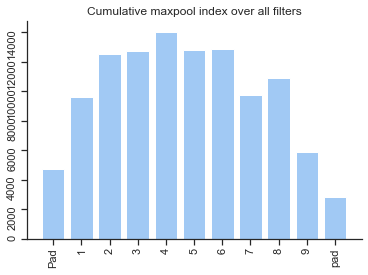

In [19]:
labels = ["Pad", "1", "2", "3", "4", "5", "6", "7", "8", "9", "pad"]
fig, ax = plt.subplots()
ax.bar(labels, total_counts)
ax.tick_params(rotation=90)
ax.set_title(f"Cumulative maxpool index over all filters")

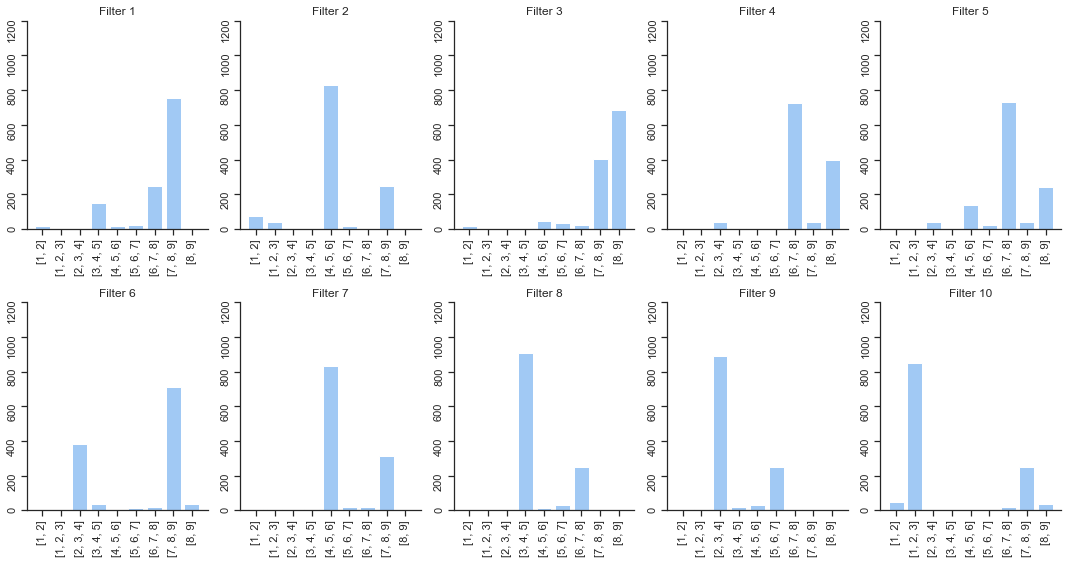

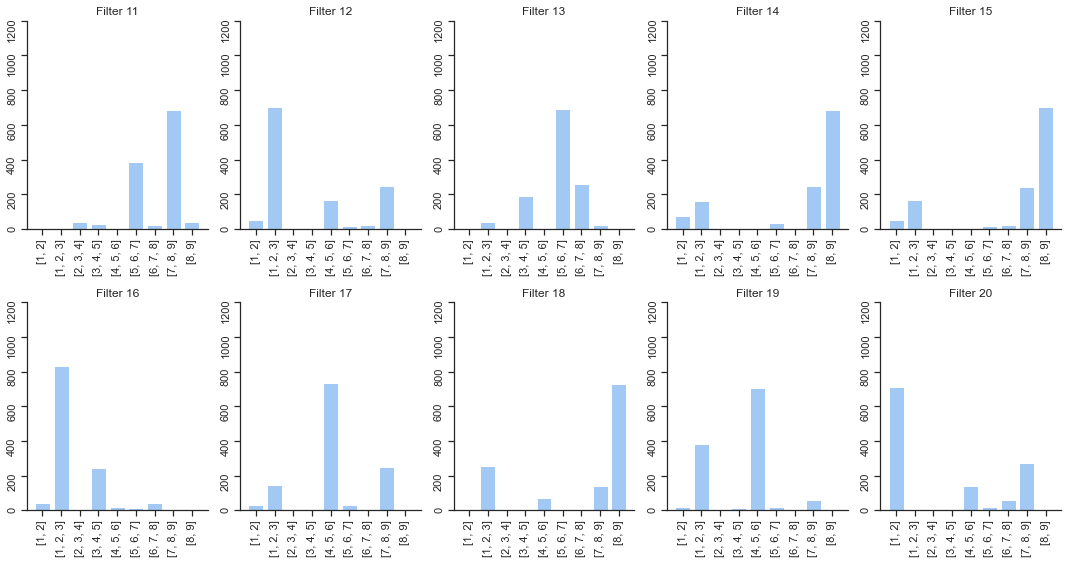

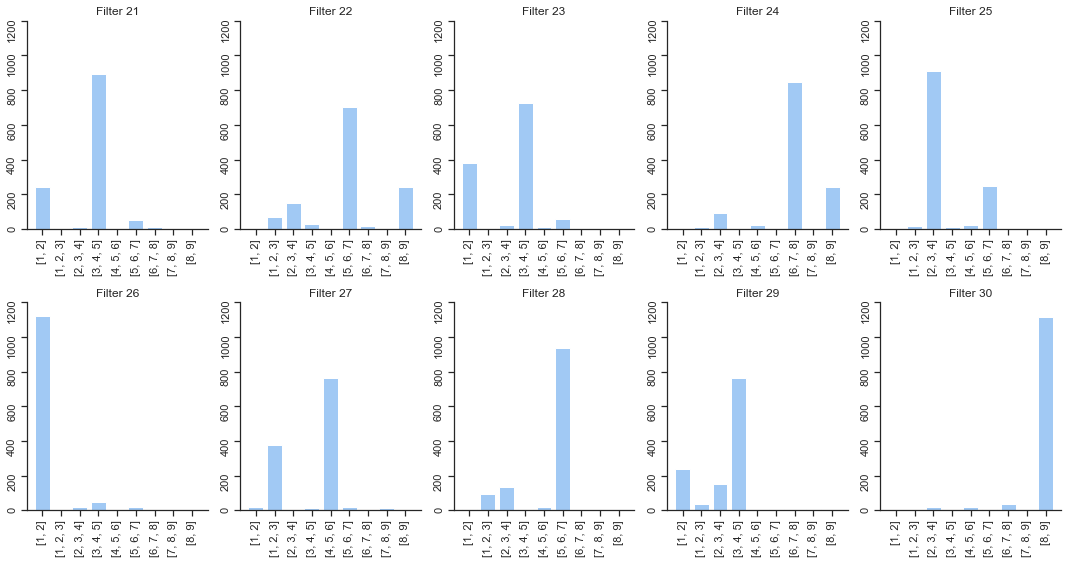

In [21]:
labels = ["[1, 2]", "[1, 2, 3]", "[2, 3, 4]", 
          "[3, 4, 5]", "[4, 5, 6]", "[5, 6, 7]",
          "[6, 7, 8]", "[7, 8, 9]", "[8, 9]"]

for i in range(3):

    fig, axs = plt.subplots(2, 5, figsize=(15,8))
    axs = axs.ravel()
    for j in range(10):
        
        axs[j].bar(labels, filter_counts[j + i*10])
        axs[j].tick_params(rotation=90)
        axs[j].set_title(f"Filter {j + i*10 + 1}")
        axs[j].set_ylim([0,1200])
    plt.tight_layout()

## Check results from CV experiment to see per peptide performance

For now only has the performance of the CDRs

In [191]:
result = pd.read_csv("../../results/modelling/simplecnn_cdr_scores.csv", index_col=0)

In [192]:
from sklearn import metrics
def calc_auc(x):
    d = {}
    d["auc"] = metrics.roc_auc_score(x["labels"],x["scores"])
    d["counts"] = len(x)
    return pd.Series(d, index=["auc", "counts"])

result = result[result["peptide"].isin(result["peptide"].value_counts(ascending=False).head(10).index)]
auc_df = result.groupby("peptide").apply(calc_auc)

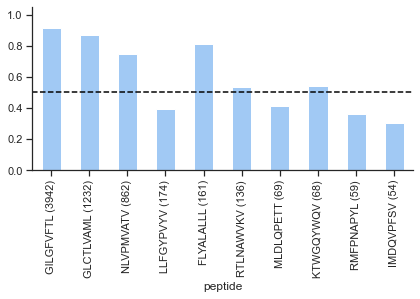

In [201]:
def get_labels(x):
    return f"{x.name} ({int(x['counts'])})"

auc_df = auc_df.sort_values("counts",ascending=False)
ax = auc_df.plot.bar(y="auc",ylim=[0,1.05])
ax.axhline(0.5, ls="--", c="black")
plt.tight_layout()
ax.get_legend().remove()
ax.set_xticklabels(auc_df.apply(get_labels, axis=1))
plt.savefig("../../results/modelling/cdr_peptide_auc.png")